In [4]:
from tensorflow.keras.applications import vgg16
from keras import models
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from keras.models import Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D,BatchNormalization, GlobalAveragePooling2D
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from keras import backend as K
from keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from keras import optimizers
import matplotlib.pyplot as plt 
import numpy as np 
from tensorflow.keras import layers
import pathlib
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
%matplotlib inline

In [5]:
test_images = "/content/"
test_data = "/content/Train.csv"

In [6]:
df = pd.read_csv(test_data )


FileNotFoundError: [Errno 2] No such file or directory: '/content/Train.csv'

In [3]:
avWidth = df["Width"].mean()
avHeight = df["Height"].mean()
print(avWidth, avHeight)

NameError: name 'df' is not defined

In [106]:
mainwidth = df.Width.mode()
mainHeight = df.Height.mode()
print(mainwidth, mainHeight)

0    31
dtype: int64 0    32
dtype: int64


In [107]:
# maybe the best is 31x32

In [108]:
data_dir = '/content'
train_path = '/content/Train'
test_path = '/content/'
IMG_HEIGHT = 32
IMG_WIDTH = 32
NUM_CATEGORIES = 43

/content/Train


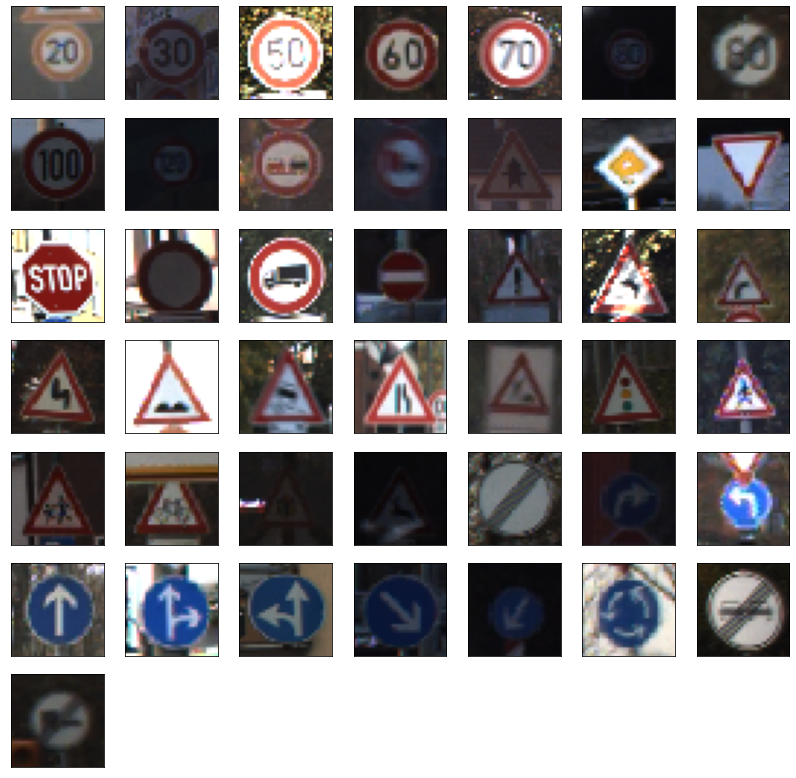

In [109]:
# Visualizing all the different Signs
img_dir = pathlib.Path(train_path)
print(img_dir)
plt.figure(figsize=(14,14))
index = 0
for i in range(NUM_CATEGORIES):
    plt.subplot(7, 7, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    sign = list(img_dir.glob(f'{i}/*'))[0]
    img = load_img(sign, target_size=(IMG_WIDTH, IMG_HEIGHT))
    plt.imshow(img)
plt.show()
    

In [110]:
def load_data(data_dir):
    '''
    Loading data from Train folder.
    
    Returns a tuple `(images, labels)` , where `images` is a list of all the images in the train directory,
    where each image is formatted as a numpy ndarray with dimensions IMG_WIDTH x IMG_HEIGHT x 3. 
    `labels` is a list of integer labels, representing the categories for each of the
    corresponding `images`.
    '''
    images = list()
    labels = list()
    for category in range(NUM_CATEGORIES):
        categories = os.path.join(data_dir, str(category))
        
        for img in os.listdir(categories):
            #print(os.path.join(categories, img))
            img = load_img(os.path.join(categories, img), target_size=(IMG_HEIGHT , IMG_WIDTH,))
            
            image = img_to_array(img)
            images.append(image)
            labels.append(category)
    
    return images, labels

In [111]:
images, labels = load_data(train_path)

# One hot encoding the labels
labels = to_categorical(labels)

# Splitting the dataset into training and test set
x_train, x_test, y_train, y_test = train_test_split(np.array(images), labels, test_size=0.4)

In [112]:
# Init the VGG model 
vgg_conv = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT , IMG_WIDTH, 3))
vgg_conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [113]:
my_model = Model(inputs=vgg_conv.input, outputs=vgg_conv.get_layer('block1_pool').output)
my_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________


In [114]:
model = Sequential()
model.add(my_model)


model.add(Conv2D(128,(3,3), activation='relu', padding="same",))
model.add(MaxPooling2D((2,2), padding="same",))
model.add(Conv2D(256,(3,3), activation='relu', padding="same",))
model.add(MaxPooling2D((2,2), padding="same",))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))

model.add(Dense(43, activation='softmax'))

model.layers[0].trainable = False

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_4 (Functional)         (None, 16, 16, 64)        38720     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 256)         295168    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 4, 256)         0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 4, 4, 256)         0         
_________________________________________________________________
global_average_pooling2d_5 ( (None, 256)              

In [115]:
# Compiling the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])



# Fitting the model
EPOCHS = 20


es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(x_train, 
                    y_train,
                    validation_data = (x_test, y_test), 
                    epochs=EPOCHS, 
                    steps_per_epoch=60,
                    callbacks = [es_callback]
                   )

Epoch 1/20
60/60 [==============================] - 4s 52ms/step - loss: 3.6708 - accuracy: 0.1139 - val_loss: 2.5665 - val_accuracy: 0.2977
Epoch 2/20
60/60 [==============================] - 3s 46ms/step - loss: 2.2258 - accuracy: 0.3837 - val_loss: 2.2457 - val_accuracy: 0.3270
Epoch 3/20
60/60 [==============================] - 3s 46ms/step - loss: 1.2840 - accuracy: 0.6366 - val_loss: 2.0925 - val_accuracy: 0.3477
Epoch 4/20
60/60 [==============================] - 3s 46ms/step - loss: 0.7544 - accuracy: 0.7917 - val_loss: 1.3930 - val_accuracy: 0.5178
Epoch 5/20
60/60 [==============================] - 3s 47ms/step - loss: 0.5064 - accuracy: 0.8612 - val_loss: 0.8738 - val_accuracy: 0.7631
Epoch 6/20
60/60 [==============================] - 3s 47ms/step - loss: 0.3434 - accuracy: 0.9058 - val_loss: 0.6276 - val_accuracy: 0.8368
Epoch 7/20
60/60 [==============================] - 3s 47ms/step - loss: 0.2560 - accuracy: 0.9288 - val_loss: 0.2844 - val_accuracy: 0.9476
Epoch 8/20
60

In [116]:
loss, accuracy = model.evaluate(x_test, y_test)

print('test set accuracy: ', accuracy * 100)

491/491 [==============================] - 2s 3ms/step - loss: 0.0221 - accuracy: 0.9937
test set accuracy:  99.36878085136414


In [120]:
model.save("VGGblock1_99-20ep.h5")
print("Saved model to disk")

Saved model to disk


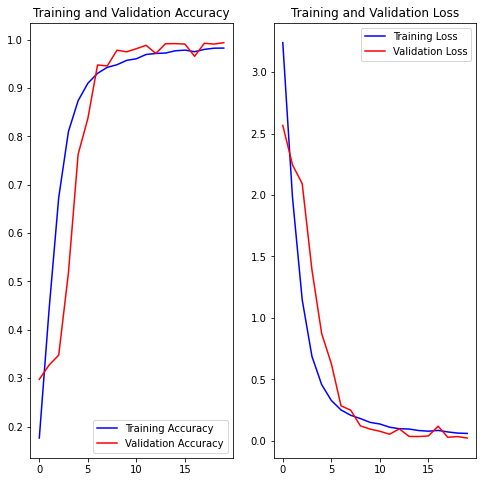

In [121]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, 'b',label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, 'r',label='Validation Accuracy')
plt.legend(loc='lower right')
plt.savefig('signs2221.svg')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss,'b', label='Training Loss')
plt.plot(epochs_range, val_loss,'r', label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('signs222.svg')
plt.show()

In [ ]:
## test data

In [122]:
from sklearn.metrics import accuracy_score
import pandas as pd

Y_test = pd.read_csv(test_path + 'Test.csv')
test_labels = Y_test["ClassId"].values
test_images = Y_test["Path"].values

output = list()
for img in test_images:
    image = load_img(os.path.join(test_path, img), target_size=(32, 32))
    output.append(np.array(image))

X_test=np.array(output)
#pred = model.predict_classes(X_test)
pred = np.argmax(model.predict(X_test), axis=-1)
#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(test_labels, pred)*100)

Test Data accuracy:  95.89865399841648


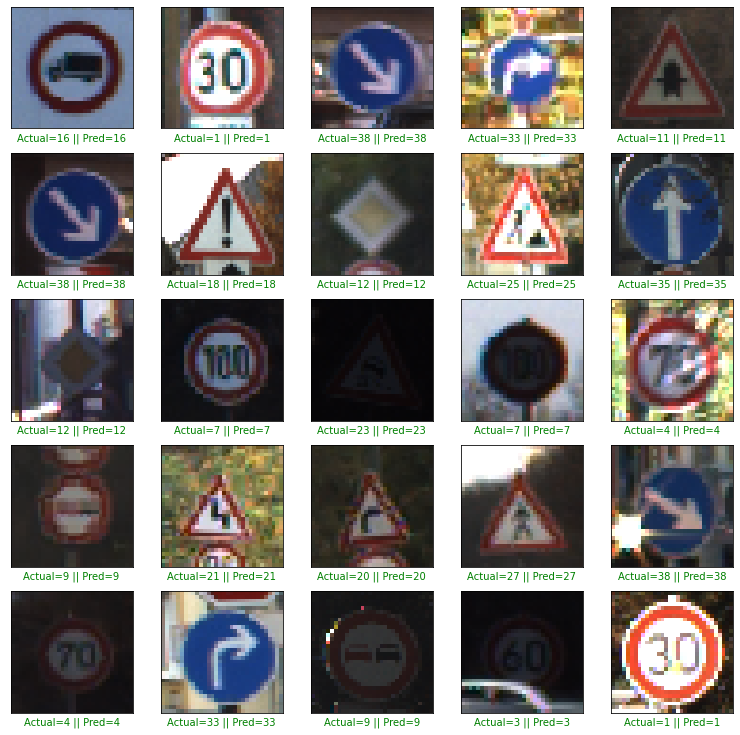

In [123]:
plt.figure(figsize = (13, 13))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = test_labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])

plt.savefig('block1.svg')  
plt.show()

In [124]:
## new model

In [149]:
vgg_conv = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT , IMG_WIDTH, 3))
vgg_conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [150]:
my_model = Model(inputs=vgg_conv.input, outputs=vgg_conv.get_layer('block2_pool').output)
my_model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [151]:
model = Sequential()
model.add(my_model)


model.add(Conv2D(128,(3,3), activation='relu', padding="same",))
model.add(MaxPooling2D((2,2), padding="same",))
model.add(Conv2D(256,(3,3), activation='relu', padding="same",))
model.add(MaxPooling2D((2,2), padding="same",))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))

model.add(Dense(43, activation='softmax'))

model.layers[0].trainable = False

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_7 (Functional)         (None, 8, 8, 128)         260160    
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 8, 128)         147584    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 4, 4, 256)         295168    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 2, 2, 256)         0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 2, 2, 256)         0         
_________________________________________________________________
global_average_pooling2d_8 ( (None, 256)              

In [152]:
# Compiling the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])



# Fitting the model
EPOCHS = 20


es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(x_train, 
                    y_train,
                    validation_data = (x_test, y_test), 
                    epochs=EPOCHS, 
                    steps_per_epoch=60,
                    callbacks = [es_callback]
                   )

Epoch 1/20
60/60 [==============================] - 4s 51ms/step - loss: 3.3690 - accuracy: 0.1908 - val_loss: 1.4872 - val_accuracy: 0.6281
Epoch 2/20
60/60 [==============================] - 3s 48ms/step - loss: 1.2647 - accuracy: 0.6645 - val_loss: 0.6451 - val_accuracy: 0.8689
Epoch 3/20
60/60 [==============================] - 3s 48ms/step - loss: 0.5437 - accuracy: 0.8595 - val_loss: 0.3372 - val_accuracy: 0.9397
Epoch 4/20
60/60 [==============================] - 3s 47ms/step - loss: 0.2939 - accuracy: 0.9255 - val_loss: 0.1575 - val_accuracy: 0.9723
Epoch 5/20
60/60 [==============================] - 3s 47ms/step - loss: 0.1662 - accuracy: 0.9597 - val_loss: 0.1134 - val_accuracy: 0.9775
Epoch 6/20
60/60 [==============================] - 3s 48ms/step - loss: 0.1216 - accuracy: 0.9717 - val_loss: 0.0749 - val_accuracy: 0.9833
Epoch 7/20
60/60 [==============================] - 3s 48ms/step - loss: 0.0944 - accuracy: 0.9773 - val_loss: 0.0554 - val_accuracy: 0.9872
Epoch 8/20
60

In [153]:
loss, accuracy = model.evaluate(x_test, y_test)

print('test set accuracy: ', accuracy * 100)

491/491 [==============================] - 2s 4ms/step - loss: 0.0239 - accuracy: 0.9932
test set accuracy:  99.3241548538208


In [154]:
model.save("VGGblock2_99-20ep.h5")
print("Saved model to disk")

Saved model to disk


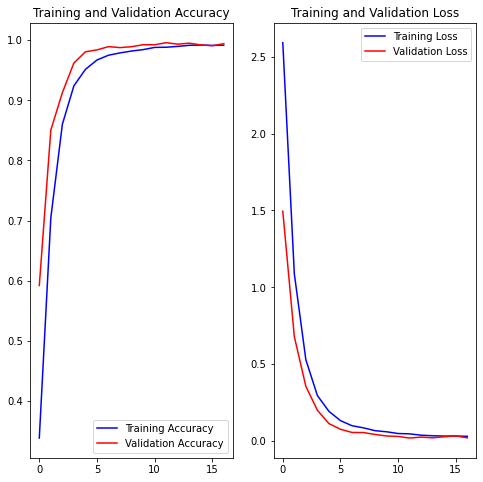

In [134]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(17)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, 'b',label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, 'r',label='Validation Accuracy')
plt.legend(loc='lower right')
plt.savefig('signs2221.svg')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss,'b', label='Training Loss')
plt.plot(epochs_range, val_loss,'r', label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('signs222.svg')
plt.show()

In [137]:
from sklearn.metrics import accuracy_score
import pandas as pd

Y_test = pd.read_csv(test_path + 'Test.csv')
test_labels = Y_test["ClassId"].values
test_images = Y_test["Path"].values

output = list()
for img in test_images:
    image = load_img(os.path.join(test_path, img), target_size=(32, 32))
    output.append(np.array(image))

X_test=np.array(output)
#pred = model.predict_classes(X_test)
pred = np.argmax(model.predict(X_test), axis=-1)
#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(test_labels, pred)*100)

Test Data accuracy:  95.28107680126683


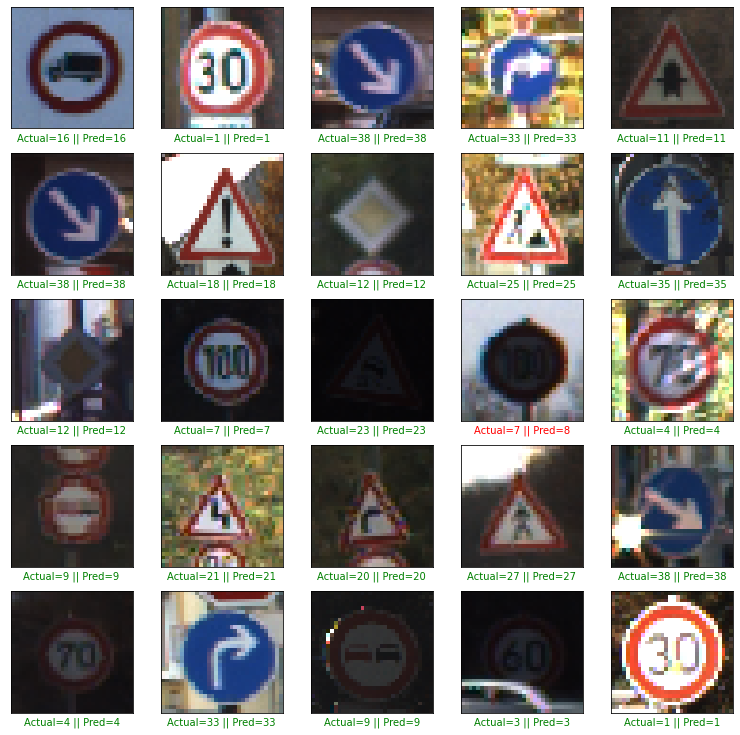

In [138]:
plt.figure(figsize = (13, 13))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = test_labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

In [208]:
## new block

In [209]:
vgg_conv = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT , IMG_WIDTH, 3))
vgg_conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [210]:
my_model = Model(inputs=vgg_conv.input, outputs=vgg_conv.get_layer('block3_pool').output)
my_model.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0  

In [211]:
model = Sequential()
model.add(my_model)


model.add(Conv2D(128,(3,3), activation='relu', padding="same",))
model.add(MaxPooling2D((2,2), padding="same",))
model.add(Conv2D(256,(3,3), activation='relu', padding="same",))
model.add(MaxPooling2D((2,2), padding="same",))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))

model.add(Dense(43, activation='softmax'))

model.layers[0].trainable = False

model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_16 (Functional)        (None, 4, 4, 256)         1735488   
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 4, 4, 128)         295040    
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 2, 2, 128)         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 2, 2, 256)         295168    
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 1, 1, 256)         0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 1, 1, 256)         0         
_________________________________________________________________
global_average_pooling2d_18  (None, 256)             

In [212]:
# Compiling the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])



# Fitting the model
EPOCHS = 20


es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(x_train, 
                    y_train,
                    validation_data = (x_test, y_test), 
                    epochs=EPOCHS, 
                    steps_per_epoch=60,
                    callbacks = [es_callback]
                   )

Epoch 1/20
60/60 [==============================] - 4s 63ms/step - loss: 3.3901 - accuracy: 0.1793 - val_loss: 1.6559 - val_accuracy: 0.5617
Epoch 2/20
60/60 [==============================] - 4s 59ms/step - loss: 1.6167 - accuracy: 0.5422 - val_loss: 1.0119 - val_accuracy: 0.7350
Epoch 3/20
60/60 [==============================] - 4s 59ms/step - loss: 0.9541 - accuracy: 0.7148 - val_loss: 0.5744 - val_accuracy: 0.8711
Epoch 4/20
60/60 [==============================] - 4s 60ms/step - loss: 0.6131 - accuracy: 0.8201 - val_loss: 0.7272 - val_accuracy: 0.8138
Epoch 5/20
60/60 [==============================] - 4s 59ms/step - loss: 0.7573 - accuracy: 0.7656 - val_loss: 0.3401 - val_accuracy: 0.9115
Epoch 6/20
60/60 [==============================] - 4s 60ms/step - loss: 0.4083 - accuracy: 0.8731 - val_loss: 0.1907 - val_accuracy: 0.9526
Epoch 7/20
60/60 [==============================] - 4s 60ms/step - loss: 0.3056 - accuracy: 0.9062 - val_loss: 0.1427 - val_accuracy: 0.9612
Epoch 8/20
60

In [143]:
loss, accuracy = model.evaluate(x_test, y_test)

print('test set accuracy: ', accuracy * 100)

491/491 [==============================] - 2s 4ms/step - loss: 0.0574 - accuracy: 0.9831
test set accuracy:  98.31038117408752


In [146]:
model.save("VGGblock3_99-20ep.h5")
print("Saved model to disk")

Saved model to disk


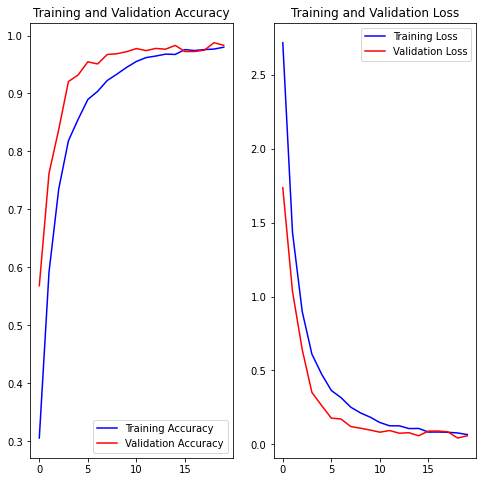

In [148]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, 'b',label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, 'r',label='Validation Accuracy')
plt.legend(loc='lower right')

plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss,'b', label='Training Loss')
plt.plot(epochs_range, val_loss,'r', label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('signs222block3.svg')
plt.show()

In [213]:
from sklearn.metrics import accuracy_score
import pandas as pd

Y_test = pd.read_csv(test_path + 'Test.csv')
test_labels = Y_test["ClassId"].values
test_images = Y_test["Path"].values

output = list()
for img in test_images:
    image = load_img(os.path.join(test_path, img), target_size=(32, 32))
    output.append(np.array(image))

X_test=np.array(output)
#pred = model.predict_classes(X_test)
pred = np.argmax(model.predict(X_test), axis=-1)
#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(test_labels, pred)*100)

Test Data accuracy:  89.61203483768804


In [ ]:
plt.figure(figsize = (13, 13))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = test_labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

In [229]:
# new model 

In [214]:
vgg_conv = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT , IMG_WIDTH, 3))
vgg_conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [215]:
my_model = Model(inputs=vgg_conv.input, outputs=vgg_conv.get_layer('block4_pool').output)
my_model.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0  

In [216]:
model = Sequential()
model.add(my_model)


model.add(Conv2D(128,(3,3), activation='relu', padding="same",))
model.add(MaxPooling2D((2,2), padding="same",))
model.add(Conv2D(256,(3,3), activation='relu', padding="same",))
model.add(MaxPooling2D((2,2), padding="same",))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))

model.add(Dense(43, activation='softmax'))

model.layers[0].trainable = False

model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_17 (Functional)        (None, 2, 2, 512)         7635264   
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 2, 2, 128)         589952    
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 1, 1, 128)         0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 1, 1, 256)         295168    
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 1, 1, 256)         0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 1, 1, 256)         0         
_________________________________________________________________
global_average_pooling2d_19  (None, 256)             

In [217]:
# Compiling the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])



# Fitting the model
EPOCHS = 40


es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(x_train, 
                    y_train,
                    validation_data = (x_test, y_test), 
                    epochs=EPOCHS, 
                    steps_per_epoch=60,
                    callbacks = [es_callback]
                   )

Epoch 1/40
60/60 [==============================] - 6s 92ms/step - loss: 3.5462 - accuracy: 0.1330 - val_loss: 2.1502 - val_accuracy: 0.3965
Epoch 2/40
60/60 [==============================] - 5s 88ms/step - loss: 2.1731 - accuracy: 0.3869 - val_loss: 1.7203 - val_accuracy: 0.5048
Epoch 3/40
60/60 [==============================] - 5s 88ms/step - loss: 1.6957 - accuracy: 0.4748 - val_loss: 1.3040 - val_accuracy: 0.5659
Epoch 4/40
60/60 [==============================] - 5s 89ms/step - loss: 1.4289 - accuracy: 0.5433 - val_loss: 1.0795 - val_accuracy: 0.6578
Epoch 5/40
60/60 [==============================] - 5s 88ms/step - loss: 1.1924 - accuracy: 0.6083 - val_loss: 0.9346 - val_accuracy: 0.7103
Epoch 6/40
60/60 [==============================] - 5s 89ms/step - loss: 1.1955 - accuracy: 0.6081 - val_loss: 0.8500 - val_accuracy: 0.7307
Epoch 7/40
60/60 [==============================] - 5s 89ms/step - loss: 0.9993 - accuracy: 0.6656 - val_loss: 0.7265 - val_accuracy: 0.7689
Epoch 8/40
60

In [218]:
loss, accuracy = model.evaluate(x_test, y_test)

print('test set accuracy: ', accuracy * 100)

491/491 [==============================] - 3s 7ms/step - loss: 0.2463 - accuracy: 0.9360
test set accuracy:  93.59857439994812


In [178]:
model.save("VGGblock4_94-29ep.h5")
print("Saved model to disk")

Saved model to disk


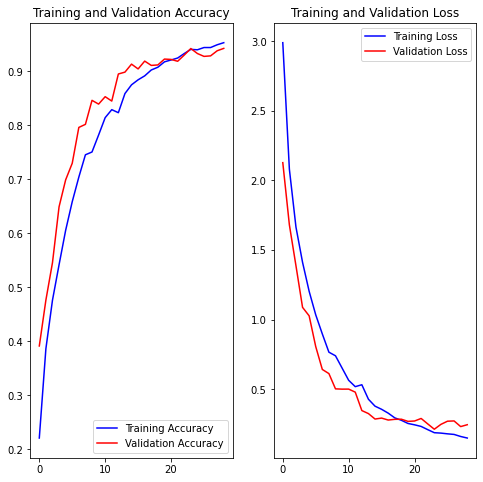

In [180]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(29)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, 'b',label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, 'r',label='Validation Accuracy')
plt.legend(loc='lower right')

plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss,'b', label='Training Loss')
plt.plot(epochs_range, val_loss,'r', label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('signs222block3.svg')
plt.show()

In [219]:
from sklearn.metrics import accuracy_score
import pandas as pd

Y_test = pd.read_csv(test_path + 'Test.csv')
test_labels = Y_test["ClassId"].values
test_images = Y_test["Path"].values

output = list()
for img in test_images:
    image = load_img(os.path.join(test_path, img), target_size=(32, 32))
    output.append(np.array(image))

X_test=np.array(output)
#pred = model.predict_classes(X_test)
pred = np.argmax(model.predict(X_test), axis=-1)
#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(test_labels, pred)*100)

Test Data accuracy:  73.27790973871734


In [ ]:
plt.figure(figsize = (13, 13))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = test_labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

In [228]:
# new model

In [220]:
vgg_conv = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT , IMG_WIDTH, 3))
vgg_conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [221]:
my_model = Model(inputs=vgg_conv.input, outputs=vgg_conv.get_layer('block5_pool').output)
my_model.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0  

In [222]:
model = Sequential()
model.add(my_model)


model.add(Conv2D(128,(3,3), activation='relu', padding="same",))
model.add(MaxPooling2D((2,2), padding="same",))
model.add(Conv2D(256,(3,3), activation='relu', padding="same",))
model.add(MaxPooling2D((2,2), padding="same",))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))

model.add(Dense(43, activation='softmax'))

model.layers[0].trainable = False

model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_18 (Functional)        (None, 1, 1, 512)         14714688  
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 1, 1, 128)         589952    
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 1, 1, 128)         0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 1, 1, 256)         295168    
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 1, 1, 256)         0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 1, 1, 256)         0         
_________________________________________________________________
global_average_pooling2d_20  (None, 256)             

In [223]:
# Compiling the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])



# Fitting the model
EPOCHS = 40


es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(x_train, 
                    y_train,
                    validation_data = (x_test, y_test), 
                    epochs=EPOCHS, 
                    steps_per_epoch=60,
                    callbacks = [es_callback]
                   )

Epoch 1/40
60/60 [==============================] - 8s 115ms/step - loss: 3.5414 - accuracy: 0.1452 - val_loss: 2.1479 - val_accuracy: 0.3950
Epoch 2/40
60/60 [==============================] - 7s 111ms/step - loss: 2.1725 - accuracy: 0.3648 - val_loss: 1.7148 - val_accuracy: 0.4957
Epoch 3/40
60/60 [==============================] - 7s 111ms/step - loss: 1.7542 - accuracy: 0.4477 - val_loss: 1.4385 - val_accuracy: 0.5587
Epoch 4/40
60/60 [==============================] - 7s 112ms/step - loss: 1.5055 - accuracy: 0.5142 - val_loss: 1.2639 - val_accuracy: 0.6080
Epoch 5/40
60/60 [==============================] - 7s 112ms/step - loss: 1.3644 - accuracy: 0.5596 - val_loss: 1.1550 - val_accuracy: 0.6382
Epoch 6/40
60/60 [==============================] - 7s 113ms/step - loss: 1.2367 - accuracy: 0.5983 - val_loss: 1.0787 - val_accuracy: 0.6519
Epoch 7/40
60/60 [==============================] - 7s 113ms/step - loss: 1.1440 - accuracy: 0.6264 - val_loss: 0.9955 - val_accuracy: 0.6787
Epoch 

In [224]:
loss, accuracy = model.evaluate(x_test, y_test)

print('test set accuracy: ', accuracy * 100)

491/491 [==============================] - 4s 9ms/step - loss: 0.6319 - accuracy: 0.8296
test set accuracy:  82.96353220939636


In [192]:
model.save("VGGblock5_84-30ep.h5")
print("Saved model to disk")

Saved model to disk


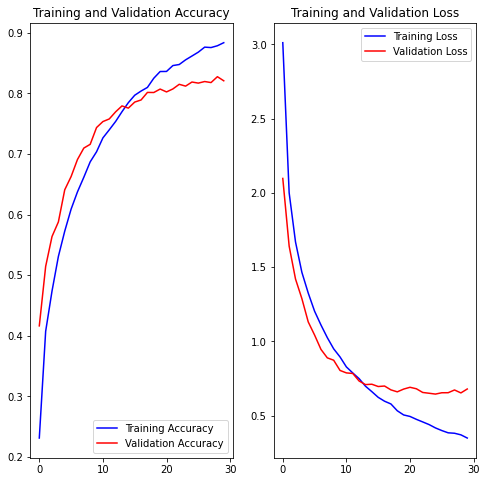

In [193]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, 'b',label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, 'r',label='Validation Accuracy')
plt.legend(loc='lower right')

plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss,'b', label='Training Loss')
plt.plot(epochs_range, val_loss,'r', label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('signs222block5.svg')
plt.show()

In [225]:
from sklearn.metrics import accuracy_score
import pandas as pd

Y_test = pd.read_csv(test_path + 'Test.csv')
test_labels = Y_test["ClassId"].values
test_images = Y_test["Path"].values

output = list()
for img in test_images:
    image = load_img(os.path.join(test_path, img), target_size=(32, 32))
    output.append(np.array(image))

X_test=np.array(output)
#pred = model.predict_classes(X_test)
pred = np.argmax(model.predict(X_test), axis=-1)
#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(test_labels, pred)*100)

Test Data accuracy:  53.10372129849564


In [ ]:
plt.figure(figsize = (13, 13))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = test_labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

In [227]:
#new model

In [195]:
vgg_conv = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT , IMG_WIDTH, 3))
vgg_conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [196]:
# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fa7fed345c0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa801103588> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa7ff6f47b8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fa7a60e0d30> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa7fed34978> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa79e5f9828> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fa7ff8675c0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa7ff6d1198> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa79e5f9710> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa7ff745908> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fa7ff7b3f28> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

In [198]:
# Create the model
model = Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dropout_36 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 43)                44075     
Total params: 15,284,075
Trainable params: 569,387
Non-trainable params: 14,714,688
_________________________________________________________________


In [199]:
# Compiling the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])



# Fitting the model
EPOCHS = 40


es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(x_train, 
                    y_train,
                    validation_data = (x_test, y_test), 
                    epochs=EPOCHS, 
                    steps_per_epoch=60,
                    callbacks = [es_callback]
                   )

Epoch 1/40
60/60 [==============================] - 7s 108ms/step - loss: 11.8406 - accuracy: 0.2588 - val_loss: 1.6036 - val_accuracy: 0.5887
Epoch 2/40
60/60 [==============================] - 6s 104ms/step - loss: 1.9630 - accuracy: 0.5257 - val_loss: 1.1199 - val_accuracy: 0.6834
Epoch 3/40
60/60 [==============================] - 6s 104ms/step - loss: 1.3206 - accuracy: 0.6234 - val_loss: 0.9558 - val_accuracy: 0.7253
Epoch 4/40
60/60 [==============================] - 6s 104ms/step - loss: 1.0226 - accuracy: 0.6949 - val_loss: 0.8325 - val_accuracy: 0.7624
Epoch 5/40
60/60 [==============================] - 6s 107ms/step - loss: 0.8554 - accuracy: 0.7367 - val_loss: 0.7578 - val_accuracy: 0.7805
Epoch 6/40
60/60 [==============================] - 6s 105ms/step - loss: 0.7374 - accuracy: 0.7645 - val_loss: 0.6971 - val_accuracy: 0.7964
Epoch 7/40
60/60 [==============================] - 6s 106ms/step - loss: 0.6513 - accuracy: 0.7882 - val_loss: 0.6568 - val_accuracy: 0.8099
Epoch

In [200]:
loss, accuracy = model.evaluate(x_test, y_test)

print('test set accuracy: ', accuracy * 100)

491/491 [==============================] - 4s 8ms/step - loss: 0.4804 - accuracy: 0.8815
test set accuracy:  88.1471574306488


In [202]:
model.save("VGGAllplus Basic_88-29ep.h5")
print("Saved model to disk")

Saved model to disk


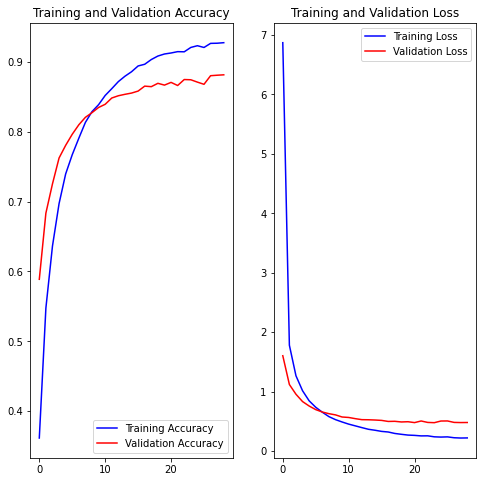

In [203]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(29)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, 'b',label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, 'r',label='Validation Accuracy')
plt.legend(loc='lower right')

plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss,'b', label='Training Loss')
plt.plot(epochs_range, val_loss,'r', label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('signs222block5.svg')
plt.show()

In [204]:
from sklearn.metrics import accuracy_score
import pandas as pd

Y_test = pd.read_csv(test_path + 'Test.csv')
test_labels = Y_test["ClassId"].values
test_images = Y_test["Path"].values

output = list()
for img in test_images:
    image = load_img(os.path.join(test_path, img), target_size=(32, 32))
    output.append(np.array(image))

X_test=np.array(output)
#pred = model.predict_classes(X_test)
pred = np.argmax(model.predict(X_test), axis=-1)
#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(test_labels, pred)*100)

Test Data accuracy:  55.36817102137768


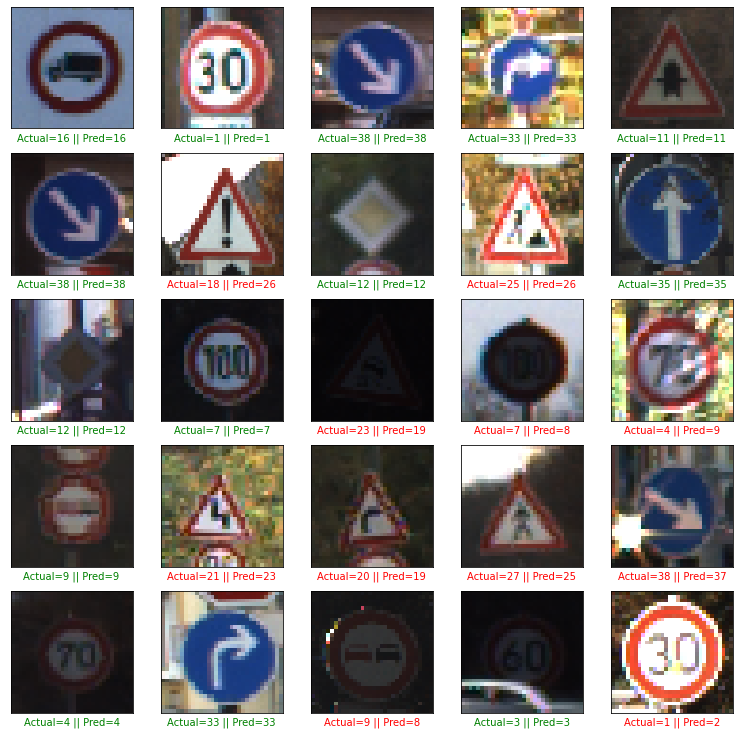

In [226]:
plt.figure(figsize = (13, 13))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = test_labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()